# Collisions

### Introduction

### What is it?

### Example

# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

**Note**, don't set very high values for velocity as the simulation might crash. If you will experience such a situation, try reducing the velocity!

In [4]:
# global
viscosity = 0.00002 # Air Resistance (this is default value for air on Earth)

# collision constants
distance = 1 # distance between two objects (center points of object) [meters]
# mass [kg]
left_mass = 0.25 # mass of left box
right_mass = 0.25 # mass of right box
# speed [m/s]
left_velocity = 1.2
right_velocity = 0

"""
Collision Type of Simulation

set to 'True' to simulate 'inelastic'
set to 'False' to simulate 'elastic'
"""
is_inelastic = False

# rendering
width = 1280
height = 720
dpi = 600
duration = 5  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
if not IS_COLAB:
  import os, sys

  module_path = os.path.abspath(os.path.join(".."))
  if module_path not in sys.path:
      sys.path.append(module_path)

  from scene import Scene

else:
  from extraphi.mechanics.scene import Scene

### Object

This class defines the object of our interest, a `box`. Here we write what is this object (box), what can it do (move, fall) and also add a camera that follows the object.

In [6]:
class Box(object):

    def __init__(
        self, side: str, rgba: list[float], mass: float, is_inelastic: bool
    ) -> None:
        self.model = mjcf.RootElement(model=f"{side}_box")

        self.box = self.model.worldbody.add("body", name="box", pos=[0, 0, 0])

        # self.box.add("inertial", pos=[0, 0, 0], mass=mass)

        solref = {}
        if not is_inelastic:
            solref["solref"] = [0.02, 0.07]

        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            pos=[0, 0, 0],
            size=[0.1, 0.05, 0.04],
            mass=mass,
            rgba=rgba,
            condim=1,
            **solref,
        )

        self.move = self.box.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.box.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        if is_inelastic:
            self.model.actuator.add(
                "adhesion",
                name=f"{side}_adhesion",
                body="box",
                ctrlrange=[0.99, 1],
                gain=2.5,
            )

### World Model

Collecting everything into one general model.

In [7]:
class Model(object):

    def __init__(self, right_mass: float, left_mass: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # setting environment constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"
        self.model.option.flag.constraint = "enable"
        self.model.option.flag.contact = "enable"
        self.model.option.flag.gravity = "enable"
        self.model.option.flag.energy = "enable"

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # create the environment (ground)
        self.arena = Scene(length=10)
        self.arena_site = self.model.worldbody.add(
            "site", name="arena_site", pos=[0, 0, -0.1], rgba=[0, 0, 0, 0]
        )
        self.arena_site.attach(self.arena.model)

        # add object1
        self.box1 = Box(
            side="left", rgba=[0, 0, 1, 1], mass=left_mass, is_inelastic=is_inelastic
        )
        box_site1 = self.model.worldbody.add(
            "site", name="left_site", pos=[-distance / 2 - 0.05, 0, 0.02], rgba=[0, 0, 0, 0]
        )
        box_site1.attach(self.box1.model)

        # add object2
        self.box2 = Box(
            side="right", rgba=[1, 0, 0, 1], mass=right_mass, is_inelastic=is_inelastic
        )
        box_site2 = self.model.worldbody.add(
            "site", name="right_site", pos=[distance / 2 + 0.05, 0, 0.02], rgba=[0, 0, 0, 0]
        )
        box_site2.attach(self.box2.model)

        self.camera = self.model.worldbody.add(
            "camera",
            name="front",
            pos=[0, -2, 1],
            euler=[60, 0, 0],
        )

## Simulation

Initializing the `physics` of the simulation.

In [8]:
model = Model(right_mass, left_mass).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture.

""

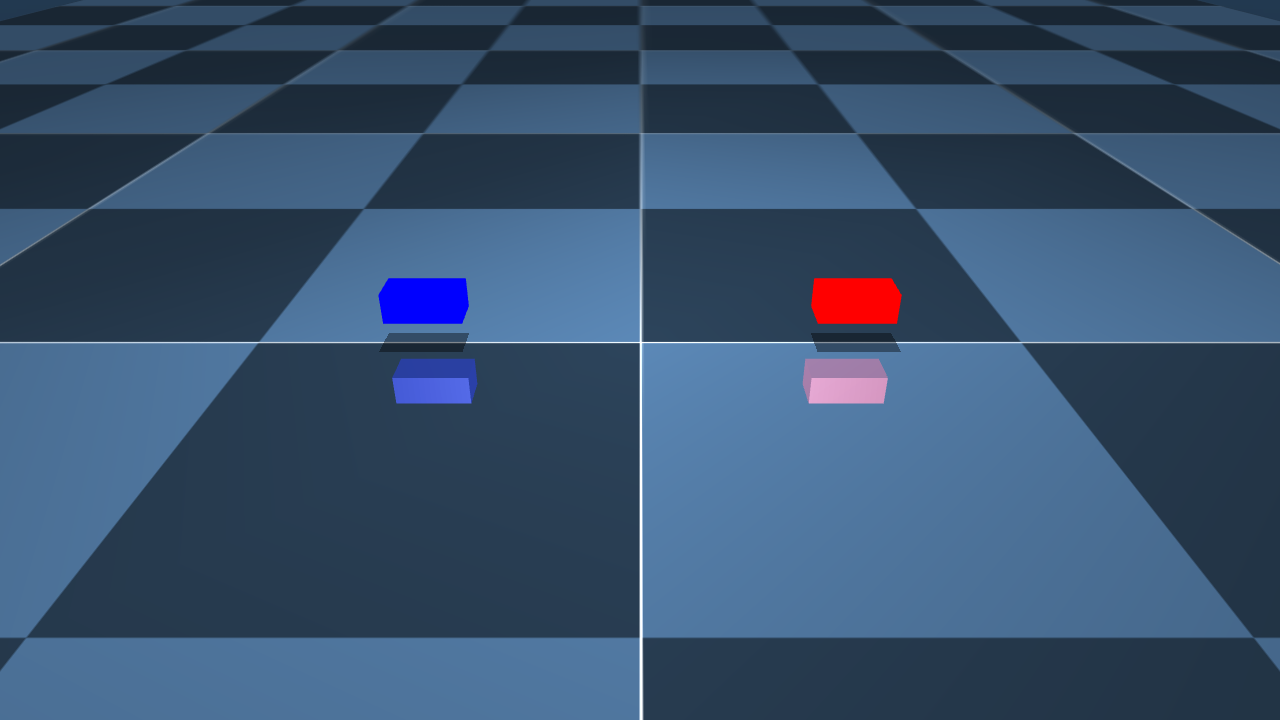

In [9]:
mediapy.show_image(physics.render(height, width, camera_id=0))

Define IDs for two objects in order to get timestamp of collision

In [10]:
box1_id = physics.model.name2id("left_box/box_geom", "geom")
box2_id = physics.model.name2id("right_box/box_geom", "geom")
box1_id, box2_id

(1, 2)

Next, it's time to make a simulation. This might take some time.

In [11]:
physics.reset()

frames = []
timevals = []
velocity = []
position = []
collisions = []

accelerate = None
while physics.data.time < duration:
    if physics.data.time >= 1.0 and not accelerate:
        physics.data.qvel = [left_velocity, 0, -right_velocity, 0]
        accelerate =True

    physics.step()

    timevals.append(physics.data.time)
    velocity.append([physics.data.qvel[0], physics.data.qvel[2]])
    position.append(
        [
            physics.named.data.geom_xpos["left_box/box_geom"][0],
            physics.named.data.geom_xpos["right_box/box_geom"][0],
        ]
    )

    for i, c in enumerate(physics.data.contact):
        if box1_id in c.geom and box2_id in c.geom:
            collisions.append((c, physics.data.time))

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(height, width, camera_id=0)
        frames.append(pixels)

In [12]:
# Simulate and display video.
mediapy.show_video(frames, fps=framerate)

Save the rendered video

In [13]:
collision_type = "inelastic" if is_inelastic else "elastic"
mass_type = "same-mass"
if left_mass != right_mass:
    mass_type = "blue" if left_mass > right_mass else "red"
    mass_type = f"{mass_type}-bigger"

In [14]:
mediapy.write_video(f"../../output/collision-{collision_type}-{mass_type}.mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [15]:
# convert velocity into numpy array to have more features
velocity = np.array(velocity)
# we split two signals into two arrays
velocity_r = velocity[:, 0]
velocity_l = velocity[:, 1]
# this line checks whether the shape of data equals, meaning that we don't lose anything
velocity_r.shape[0] == velocity_l.shape[0] == velocity.shape[0]

True

In [16]:
# convert position into numpy array to have more features
position = np.array(position)
# we split two signals into two arrays
position_r = position[:, 0]
position_l = position[:, 1]
# this line checks whether the shape of data equals, meaning that we don't lose anything
position_r.shape[0] == position_l.shape[0] == position.shape[0]

True

## Simulation Data Visualization

Collected velocities and position now can be plotted to investigate what happened to the object.

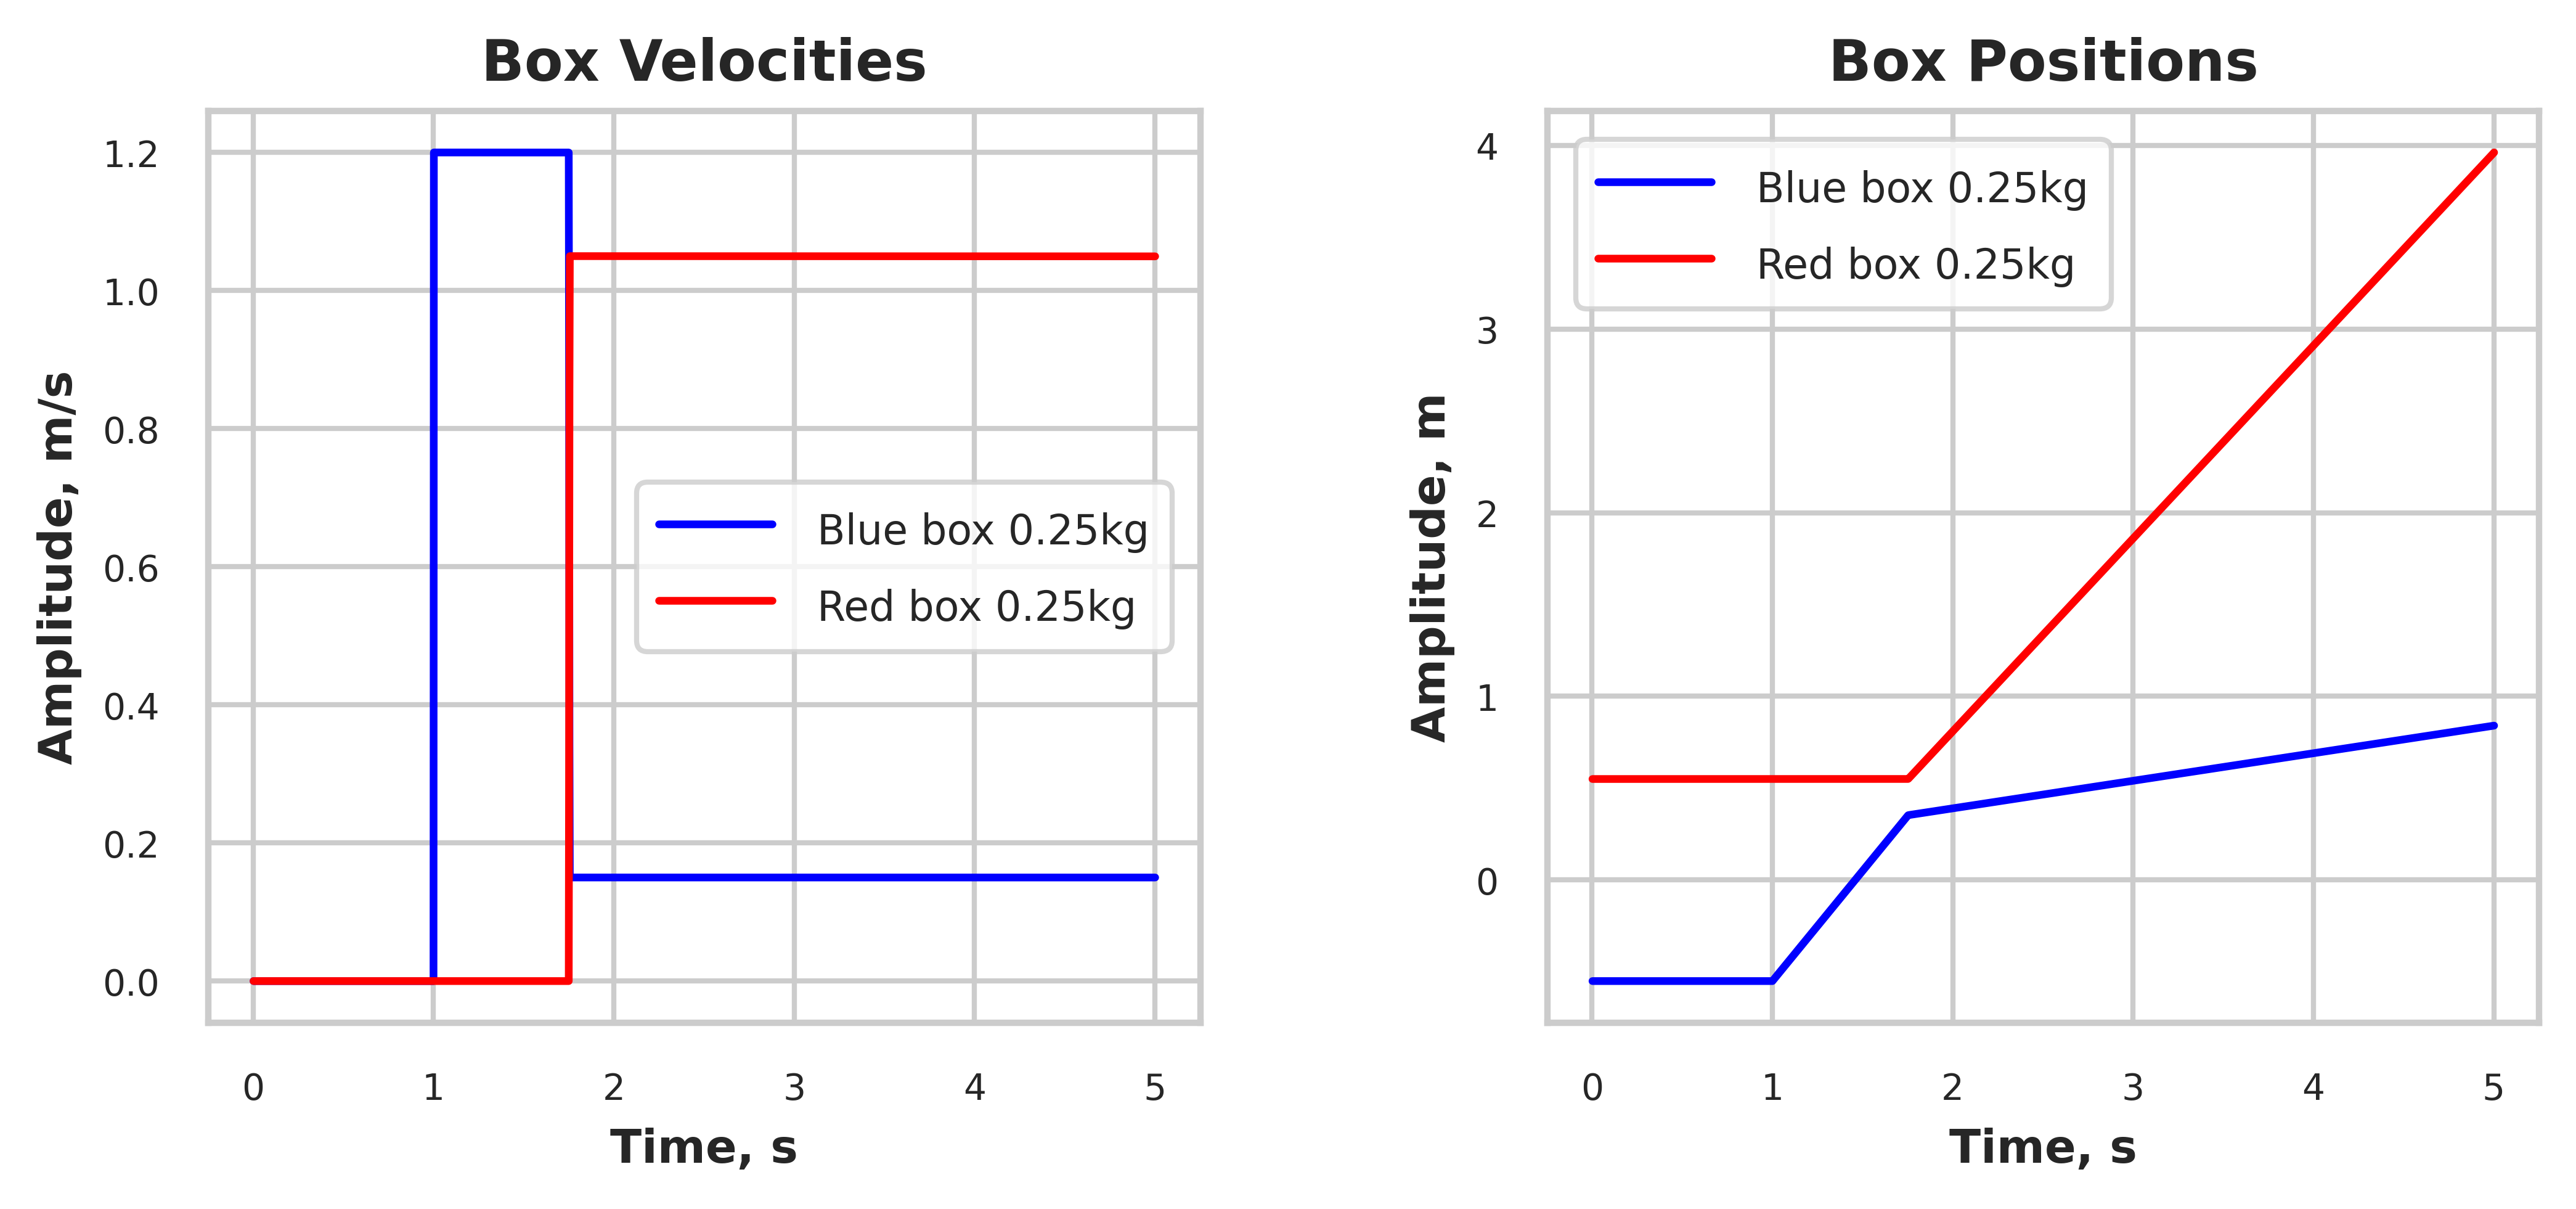

In [17]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(ncols=2, figsize=figsize, dpi=dpi, sharex=True)
fig.subplots_adjust(wspace=0.35)

# velocity
sns.lineplot(x=timevals, y=velocity_r, ax=ax[0], label=f"Blue box {physics.model.body('left_box/box').mass[0]}kg", color="blue")
sns.lineplot(x=timevals, y=velocity_l, ax=ax[0], label=f"Red box {physics.model.body('right_box/box').mass[0]}kg", color="red")
ax[0].set_title("Box Velocities", weight="bold", fontsize=11)
ax[0].set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax[0].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)
plt.setp(ax[0].get_legend().get_texts(), fontsize='8') # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize='8') # for legend title

# position
sns.lineplot(x=timevals, y=position_r, ax=ax[1], label=f"Blue box {physics.model.body('left_box/box').mass[0]}kg", color="blue")
sns.lineplot(x=timevals, y=position_l, ax=ax[1], label=f"Red box {physics.model.body('right_box/box').mass[0]}kg", color="red")
ax[1].set_title("Box Positions", weight="bold", fontsize=11)
ax[1].set_ylabel("Amplitude, m", weight="bold", fontsize=9)
ax[1].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)
plt.setp(ax[1].get_legend().get_texts(), fontsize='8') # for legend text
plt.setp(ax[1].get_legend().get_title(), fontsize='8') # for legend title

plt.savefig(f"../../output/collision-{collision_type}-{mass_type}.png", bbox_inches='tight')